In [6]:
# Load dataset from Hugging Face
!pip install datasets
from datasets import load_dataset

ds = load_dataset("Teklia/IAM-line")

# Display dataset structure
print(ds)

C:\Users\Prasa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 6482
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 976
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 2915
    })
})


In [7]:
# DATA :
!wget -q https://git.io/J0fjL -O IAM_Words.zip

!unzip -qq IAM_Words.zip

!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file data already exists.
The syntax of the command is incorrect.
tar: Error opening archive: Failed to open 'IAM_Words/words.tgz'
'mv' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
!head -20 data/words.txt

'head' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
# NECESSARY LIBRARIES :
!pip install tensorflow
from tensorflow.keras.layers import StringLookup
from tensorflow import keras
!pip install tensorflow.python.ops.numpy_ops
from tensorflow.python.ops.numpy_ops import np_config
from collections import defaultdict
from dataclasses import dataclass
from typing import List
from sklearn.cluster import DBSCAN
from PIL import Image as im

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import re
import pickle
import cv2
import math
import argparse

np.random.seed(42)
tf.random.set_seed(42)

  Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.whl (375.7 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\Prasa\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



ModuleNotFoundError: No module named 'tensorflow.python'

In [14]:
# WORDS DATA :
base_path = "/content/data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
  if line[0] =="#":
    continue
  if line.split(" ")[1] != "err":
    words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/words.txt'

In [ ]:
print(words_list[0:10])

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n', 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n', 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n', 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n', 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n', 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy\n', 'n03-082-04-03 ok 165 992 1414 118 135 NN boy\n', 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The\n', 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and\n', 'f04-024-01-06 ok 183 1104 981 60 70 IN in\n']


In [ ]:
# TRAIN, TEST AND VALIDATION SPLIT :
split_idx = int(0.9*len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total Training Samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total Training Samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [ ]:
# TRAIN, TEST AND VALIDATION DATA :
base_image_path = os.path.join(base_path, "words")
print(base_path)
def get_image_paths_and_labels(samples):
  paths = []
  corrected_samples = []
  for (i, file_line) in enumerate(samples):
    line_split = file_line.strip()
    line_split = line_split.split(" ")

    # Each line split will have this format for the the corresponding image:
    # part1/part1-part2/part1-part2-part3.png
    image_name = line_split[0]
    partI = image_name.split("-")[0]
    partII = image_name.split("-")[1]
    img_path = os.path.join(
        base_image_path, partI, partI + "-" + partII, image_name + ".png"
    )
    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_samples.append(file_line.split("\n")[0])

  return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

/content/data


In [ ]:
# CLONING THE GITHUB REPOSITORY :
!git clone https://github.com/furqan4545/handwritten_text_detection_and_recognition.git

Cloning into 'handwritten_text_detection_and_recognition'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 210 (delta 43), reused 202 (delta 35), pack-reused 0 (from 0)
Receiving objects: 100% (210/210), 5.22 MiB | 17.58 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
# TEST IMAGES :
base_image_path = os.path.join(base_path, "/content/handwritten_text_detection_and_recognition/test_imgs")
print(base_image_path)

t_images = []
from os import listdir
from os.path import isfile, join

for f in listdir(base_image_path):
  t_images_path = os.path.join(base_image_path, f)
  t_images.append(t_images_path)

print(t_images)

/content/handwritten_text_detection_and_recognition/test_imgs
['/content/handwritten_text_detection_and_recognition/test_imgs/line7word6.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line3word0.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line5word4.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line7word1.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line4word6.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line4word5.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line0word0.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line0word2.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line6word3.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line2word2.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line9word8.jpg', '/content/handwritten_text_detection_and_recognition/test

In [ ]:
t_images[0:10]

['/content/handwritten_text_detection_and_recognition/test_imgs/line7word6.jpg',
 '/content/handwritten_text_detection_and_recognition/test_imgs/line3word0.jpg',
 '/content/handwritten_text_detection_and_recognition/test_imgs/line5word4.jpg',
 '/content/handwritten_text_detection_and_recognition/test_imgs/line7word1.jpg',
 '/content/handwritten_text_detection_and_recognition/test_imgs/line4word6.jpg',
 '/content/handwritten_text_detection_and_recognition/test_imgs/line4word5.jpg',
 '/content/handwritten_text_detection_and_recognition/test_imgs/line0word0.jpg',
 '/content/handwritten_text_detection_and_recognition/test_imgs/line0word2.jpg',
 '/content/handwritten_text_detection_and_recognition/test_imgs/line6word3.jpg',
 '/content/handwritten_text_detection_and_recognition/test_imgs/line2word2.jpg']

In [ ]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

t_images.sort(key=natural_keys)
print(t_images)

['/content/handwritten_text_detection_and_recognition/test_imgs/line0word0.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line0word1.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line0word2.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line0word3.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line0word4.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line1word0.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line1word1.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line1word2.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line1word3.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line1word4.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line1word5.jpg', '/content/handwritten_text_detection_and_recognition/test_imgs/line1word6.jpg', '/content/handwritten_text_detection_an

In [ ]:
# TRAIN IMAGES :
train_img_paths[0:10]

['/content/data/words/e04/e04-030/e04-030-04-08.png',
 '/content/data/words/k02/k02-102/k02-102-05-03.png',
 '/content/data/words/a01/a01-082u/a01-082u-01-04.png',
 '/content/data/words/m01/m01-000/m01-000-07-00.png',
 '/content/data/words/g01/g01-031/g01-031-07-06.png',
 '/content/data/words/f07/f07-081b/f07-081b-01-06.png',
 '/content/data/words/n03/n03-082/n03-082-04-03.png',
 '/content/data/words/g06/g06-018c/g06-018c-04-05.png',
 '/content/data/words/g06/g06-011j/g06-011j-06-06.png',
 '/content/data/words/f04/f04-024/f04-024-01-06.png']

In [ ]:
# TRAIN LABELS :
train_labels[0: 10]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in']

In [ ]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)

  max_len = max(max_len, len(label))
  train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [ ]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    cleaned_labels.append(label)
  return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [ ]:
ff = list(characters)

In [ ]:
import pickle
with open("/content/handwritten_text_detection_and_recognition/characters", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
    print(b)

['L', 'E', '"', '0', '2', 's', 'l', 'w', 'p', 'P', 'H', '/', 'O', 'V', 'f', '!', 'X', 'v', 'M', ':', 'N', '4', '3', "'", 'F', 'J', '(', 'K', '+', 'o', '#', 'I', 'r', '9', ',', '&', '8', 'B', '*', 'Q', 'g', '.', 'W', 'j', 'q', 'm', 'c', '5', ';', '7', 'U', 'h', 'u', 'a', ')', 'R', 'i', 'C', 'z', 'n', '-', 'Y', 'D', 'x', 'd', 'S', 'y', 'Z', 'e', 'k', 'G', '?', 'T', 'A', '6', 't', '1', 'b']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Maping characaters to integers
char_to_num = StringLookup(vocabulary=b, mask_token=None)

#Maping integers back to original characters
num_to_chars = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


In [ ]:
import os
import re
import pickle
import tensorflow as tf
from tensorflow.keras.layers import StringLookup

class HandwritingDataset:
    def __init__(self, data_path, char_vocab_path):
        self.data_path = data_path
        self.base_image_path = os.path.join(data_path, "words")
        self.char_vocab_path = char_vocab_path
        self.words_list = self.load_words_list()
        self.characters = set()
        self.max_len = 0

        self.train_samples, self.validation_samples, self.test_samples = self.split_data()
        self.train_labels_cleaned, self.validation_labels_cleaned, self.test_labels_cleaned = self.process_labels()

    def load_words_list(self):
        with open(os.path.join(self.data_path, "words.txt"), "r") as file:
            words_list = file.readlines()
        return words_list

    def split_data(self):
        split_idx = int(0.9 * len(self.words_list))
        train_samples = self.words_list[:split_idx]
        test_samples = self.words_list[split_idx:]

        val_split_idx = int(0.5 * len(test_samples))
        validation_samples = test_samples[:val_split_idx]
        test_samples = test_samples[val_split_idx:]

        return train_samples, validation_samples, test_samples

    def process_labels(self):
        def clean_labels(samples):
            cleaned_labels = []
            for label in samples:
                cleaned_label = label.split(" ")[-1].strip()
                self.characters.update(cleaned_label)
                self.max_len = max(self.max_len, len(cleaned_label))
                cleaned_labels.append(cleaned_label)
            return cleaned_labels

        train_labels = clean_labels(self.train_samples)
        validation_labels = clean_labels(self.validation_samples)
        test_labels = clean_labels(self.test_samples)

        return train_labels, validation_labels, test_labels

    def load_image_paths(self, samples):
        paths, cleaned_samples = [], []
        for line in samples:
            image_name = line.split(" ")[0]

        # Check if image_name has the expected format with at least two parts separated by "-"
            if "-" in image_name and len(image_name.split("-")) >= 2:
                partI, partII = image_name.split("-")[:2]
                img_path = os.path.join(self.base_image_path, partI, f"{partI}-{partII}", f"{image_name}.png")

            # Only include paths where the image exists and has size > 0
                if os.path.exists(img_path) and os.path.getsize(img_path) > 0:
                    paths.append(img_path)
                    cleaned_samples.append(line.strip())
            else:
                print(f"Skipping invalid entry: {line.strip()}")  # Optional: log invalid entries

        return paths, cleaned_samples


    def load_character_mapping(self):
        with open(self.char_vocab_path, "rb") as file:
            character_set = pickle.load(file)

        self.char_to_num = StringLookup(vocabulary=character_set, mask_token=None)
        self.num_to_char = StringLookup(vocabulary=self.char_to_num.get_vocabulary(), mask_token=None, invert=True)

    def sort_images_naturally(self, image_paths):
        def atoi(text):
            return int(text) if text.isdigit() else text

        def natural_keys(text):
            return [atoi(c) for c in re.split(r'(\d+)', text)]

        image_paths.sort(key=natural_keys)
        return image_paths

In [ ]:
# Usage Example:
data_path = "/content/data"
char_vocab_path = "/content/handwritten_text_detection_and_recognition/characters"
dataset = HandwritingDataset(data_path, char_vocab_path)

dataset.load_character_mapping()
train_img_paths, train_labels = dataset.load_image_paths(dataset.train_samples)
validation_img_paths, validation_labels = dataset.load_image_paths(dataset.validation_samples)
test_img_paths, test_labels = dataset.load_image_paths(dataset.test_samples)

train_img_paths_sorted = dataset.sort_images_naturally(train_img_paths)

print(f"Max label length: {dataset.max_len}")
print(f"Vocabulary size: {len(dataset.characters)}")
print(f"First 10 training image paths: {train_img_paths_sorted[:10]}")
print(f"First 10 training labels: {dataset.train_labels_cleaned[:10]}")


Skipping invalid entry: #
Skipping invalid entry: # iam database word information
Skipping invalid entry: #
Skipping invalid entry: # format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
Skipping invalid entry: #
Skipping invalid entry: #     a01-000u-00-00  -> word id for line 00 in form a01-000u
Skipping invalid entry: #     ok              -> result of word segmentation
Skipping invalid entry: #                            ok: word was correctly
Skipping invalid entry: #                            er: segmentation of word can be bad
Skipping invalid entry: #
Skipping invalid entry: #     154             -> graylevel to binarize the line containing this word
Skipping invalid entry: #     1               -> number of components for this word
Skipping invalid entry: #     408 768 27 51   -> bounding box around this word in x,y,w,h format
Skipping invalid entry: #     AT              -> the grammatical tag for this word, see the
Skipping invalid entry: #                        file tagset.

In [ ]:
def distortion_free_resize(image, img_size):
  w, h = img_size
  image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

  # Check tha amount of padding needed to be done.
  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

  # only necessary if you want to do same amount of padding on both sides.
  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height +1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width % 2 != 0:
    width = pad_width // 2
    pad_width_left = width + 1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width // 2

  image = tf.pad(
      image, paddings=[
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0, 0],
      ],
  )
  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)
  return image


In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len - length
  label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
  return label


def process_images_labels(image_path, label):
  image = preprocess_image(image_path)
  label = vectorize_label(label)
  return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
    process_images_labels, num_parallel_calls=AUTOTUNE
  )

  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


In [ ]:
# Testing inference images
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def process_images_2(image_path):
  image = preprocess_image(image_path)
  # label = vectorize_label(label)
  return {"image": image}

def prepare_test_images(image_paths):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths)).map(
    process_images_2, num_parallel_calls=AUTOTUNE
  )

  # return dataset
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

inf_images = prepare_test_images(t_images)

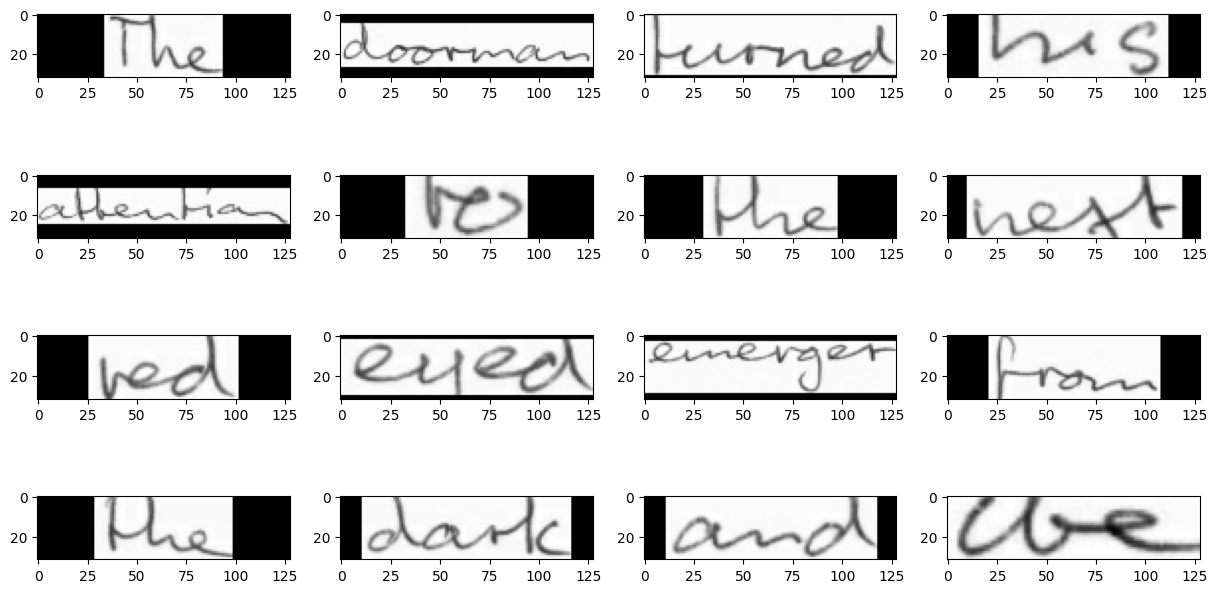

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

for data in inf_images.take(1):
  images = data["image"]
  # imm = images.reshape(images.shape[0], (images.shape[1]*images.shape[2]))
  # imm = imm.transpose()
  # print(imm.shape)
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  # ss = plt.imshow(imm, cmap="gray")
  # plt.show()
  for i in range(16):
    img = images[i]
    # print(img.shape)
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    # Gather indices where Label!= padding token

    ax[i // 4, i % 4].imshow(img, cmap="gray")


  plt.show()

In [5]:
for data in train_ds.take(1):
  images, labels = data["image"], data["label"]
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  for i in range(16):
    img = images[i]
    # print(img.shape)
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    # Gather indices where Label!= padding token
    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string.
    label = tf.strings.reduce_join(num_to_chars(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")

  plt.show()

NameError: name 'train_ds' is not defined

In [ ]:
import tensorflow as tf

class ImagePreprocessor:
    def __init__(self, image_size=(128, 32), padding_token=99):
        self.image_width, self.image_height = image_size
        self.padding_token = padding_token

    def distortion_free_resize(self, image):
        """Resizes the image without distortion."""
        w, h = self.image_width, self.image_height
        image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

        # Calculate padding
        pad_height = h - tf.shape(image)[0]
        pad_width = w - tf.shape(image)[1]

        # Apply padding evenly on both sides
        pad_height_top = pad_height // 2
        pad_height_bottom = pad_height - pad_height_top
        pad_width_left = pad_width // 2
        pad_width_right = pad_width - pad_width_left

        image = tf.pad(image, paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0]
        ])

        image = tf.transpose(image, perm=[1, 0, 2])  # Swap width and height
        image = tf.image.flip_left_right(image)  # Flip the image horizontally
        return image

    def preprocess_image(self, image_path):
        """Read and preprocess the image."""
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, 1)  # Decode as grayscale
        image = self.distortion_free_resize(image)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize image
        return image


In [ ]:
class LabelVectorizer:
    def __init__(self, max_len=100, padding_token=99):
        self.max_len = max_len
        self.padding_token = padding_token  # Keep padding_token as an integer

    def vectorize_label(self, label):
        """Vectorizes the label string and pads it."""
        label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        length = tf.shape(label)[0]

        # Use TensorFlow's tf.maximum instead of Python's max()
        pad_amount = tf.maximum(0, self.max_len - length)

        # Use integer padding token directly
        label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=self.padding_token)
        return label


In [ ]:
class DatasetProcessor:
    def __init__(self, image_preprocessor, label_vectorizer, batch_size=64):
        self.image_preprocessor = image_preprocessor
        self.label_vectorizer = label_vectorizer
        self.batch_size = batch_size
        self.AUTOTUNE = tf.data.AUTOTUNE

    def process_images_labels(self, image_path, label):
        """Process images and labels."""
        image = self.image_preprocessor.preprocess_image(image_path)
        label = self.label_vectorizer.vectorize_label(label)
        return {"image": image, "label": label}

    def prepare_dataset(self, image_paths, labels):
        """Prepare the dataset by batching and prefetching."""
        # Ensure that image_paths and labels are in the right shape
        image_paths_tensor = tf.constant(image_paths)
        labels_tensor = tf.constant(labels)

        # Check if tensor shapes are correct
        print("Image Paths Shape:", image_paths_tensor.shape)
        print("Labels Shape:", labels_tensor.shape)

        # Create the dataset
        dataset = tf.data.Dataset.from_tensor_slices((image_paths_tensor, labels_tensor)).map(
            self.process_images_labels, num_parallel_calls=self.AUTOTUNE
        )
        return dataset.batch(self.batch_size).cache().prefetch(self.AUTOTUNE)


In [ ]:
class InferenceDatasetProcessor:
    def __init__(self, image_preprocessor, batch_size=64):
        self.image_preprocessor = image_preprocessor
        self.batch_size = batch_size
        self.AUTOTUNE = tf.data.AUTOTUNE

    def process_images_2(self, image_path):
        """Process inference images."""
        image = self.image_preprocessor.preprocess_image(image_path)
        return {"image": image}

    def prepare_inference_images(self, image_paths):
        """Prepare the inference dataset."""
        dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(
            self.process_images_2, num_parallel_calls=self.AUTOTUNE
        )
        return dataset.batch(self.batch_size).cache().prefetch(self.AUTOTUNE)

In [6]:
import matplotlib.pyplot as plt

class Visualizer:
    def __init__(self, padding_token=99):
        self.padding_token = padding_token

    def display_images_with_labels(self, dataset, max_display=16):
        """Display images with their corresponding labels."""
        _, ax = plt.subplots(4, 4, figsize=(15, 8))

        for i, data in enumerate(dataset.take(1)):  # Taking first batch
            images, labels = data["image"], data["label"]
            for j in range(min(max_display, images.shape[0])):
                img = images[j]
                img = tf.image.flip_left_right(img)
                img = tf.transpose(img, perm=[1, 0, 2])  # Transpose (width, height)
                img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
                img = img[:, :, 0]

                # Decode the label and remove padding tokens
                label = labels[j]
                indices = tf.gather(label, tf.where(tf.math.not_equal(label, self.padding_token)))
                label = tf.strings.reduce_join(num_to_chars(indices)).numpy().decode("utf-8")

                ax[j // 4, j % 4].imshow(img, cmap="gray")
                ax[j // 4, j % 4].set_title(label)
                ax[j // 4, j % 4].axis("off")

        plt.show()

    def display_inference_images(self, dataset, max_display=16):
        """Display images without labels (inference images)."""
        _, ax = plt.subplots(4, 4, figsize=(15, 8))

        for i, data in enumerate(dataset.take(1)):  # Taking first batch
            images = data["image"]
            for j in range(min(max_display, images.shape[0])):
                img = images[j]
                img = tf.image.flip_left_right(img)
                img = tf.transpose(img, perm=[1, 0, 2])  # Transpose (width, height)
                img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
                img = img[:, :, 0]

                ax[j // 4, j % 4].imshow(img, cmap="gray")
                ax[j // 4, j % 4].axis("off")

        plt.show()


ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# Instantiate the necessary classes
image_preprocessor = ImagePreprocessor(image_size=(128, 32), padding_token=99)
label_vectorizer = LabelVectorizer(max_len=100, padding_token=99)  # Provide max_len here
dataset_processor = DatasetProcessor(image_preprocessor, label_vectorizer, batch_size=64)
inference_processor = InferenceDatasetProcessor(image_preprocessor, batch_size=64)

# Prepare datasets
train_ds = dataset_processor.prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = dataset_processor.prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = dataset_processor.prepare_dataset(test_img_paths, test_labels_cleaned)

# Prepare inference images
inf_images = inference_processor.prepare_inference_images(t_images)

# Visualize images and labels for training data
Visualizer.display_images_with_labels(train_ds)

# Visualize images for inference data
Visualizer.display_inference_images(inf_images)

In [ ]:
class CTCLayer(keras.layers.Layer):

  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    # At test time, just return the computed predictions.
    return y_pred

def build_model():
  input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
  labels = keras.layers.Input(name="label", shape=(None,))

  # first conv block
  x = keras.layers.Conv2D(
      32, (3,3), activation = "relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv1"
  )(input_img)
  x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)

  # Second conv block
  x = keras.layers.Conv2D(
      64, (3,3), activation = "relu", kernel_initializer="he_normal",
      padding="same",
      name="Conv2"
  )(x)
  x = keras.layers.MaxPooling2D((2,2), name="pool2")(x)

  # We have two maxpool layers with pool size and strides 2
  # Hence downsampled feature maps are 4x smaller the number of filters in the last layer is 64,
  # Reshape accordingly before passing the output to the RNN part of the model.

  new_shape = ((image_width // 4), (image_height // 4) * 64)
  x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  # RNN
  x = keras.layers.Bidirectional(
      keras.layers.LSTM(128, return_sequences=True, dropout=0.25, return_state = False)
  )(x)
  x = keras.layers.Bidirectional(
    keras.layers.LSTM(64, return_sequences=True, dropout=0.25, return_state = False)
  )(x)
  # +2 is to account for the two special tokens introduced by the CTC loss.
  # The recommendation comes here: https://git.10/J0eXP.
  x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
  )(x)
  # Add CTC layer for calculating CTC Loss at each step.
  output = CTCLayer(name="ctc_loss")(labels, x)

  # Define the model.
  model = keras.models.Model(
      inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
  )

  # optimizer
  opt = keras.optimizers.Adam()
  # Compile the model and return
  model.compile(optimizer=opt)
  return model

# Get the model
model = build_model()
model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 128, 32, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 32, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 16, 32)     │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 64, 16, 64)     │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 32, 8, 64)      │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 512)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 32, 64)         │         32,832 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 32, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 32, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 32, 81)         │         10,449 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 32, 81)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 424,081 (1.62 MB)

 Trainable params: 424,081 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])

In [ ]:
def calculate_edit_distance(labels, predictions):
  # Get a single batch and convert its labels to sparse tensors.
  sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

  # Make predictions and convert them to sparse tensors.
  input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
  predictions_decoded = keras.backend.ctc_decode(
    predictions, input_length=input_len, greedy=True
  )[0][0][:, :max_len]
  sparse_predictions = tf.cast(
    tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
  )

  # Compute individual edit distances and average them out.
  edit_distances = tf.edit_distance(
    sparse_predictions, sparse_labels, normalize=False
  )
  return tf.reduce_mean(edit_distances)


In [ ]:
class EditDistanceCallback(keras.callbacks.Callback):
  def __init__(self, pred_model):
    super().__init__()
    self.prediction_model = pred_model
  def on_epoch_end(self, epoch, logs = None):
    edit_distances = []

    for i in range(len(validation_images)):
      labels = validation_labels[i]
      predictions = self.prediction_model.predict(validation_images[i])
      edit_distances.append(calculate_edit_distance(labels, predictions).numpy())
    print(f"Mean edit distance for each {epoch + 1}: {np.mean(edit_distances): .4f}")

In [ ]:
# Training
epochs = 50 # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
  model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  callbacks=[edit_distance_callback],
)

In [1]:
#model.save("text_rec.h5")
#prediction_model.save("text_rec_50_epoch.h5")

(64, 128, 32, 1)
2/2 [==============================] - 1s 13ms/step


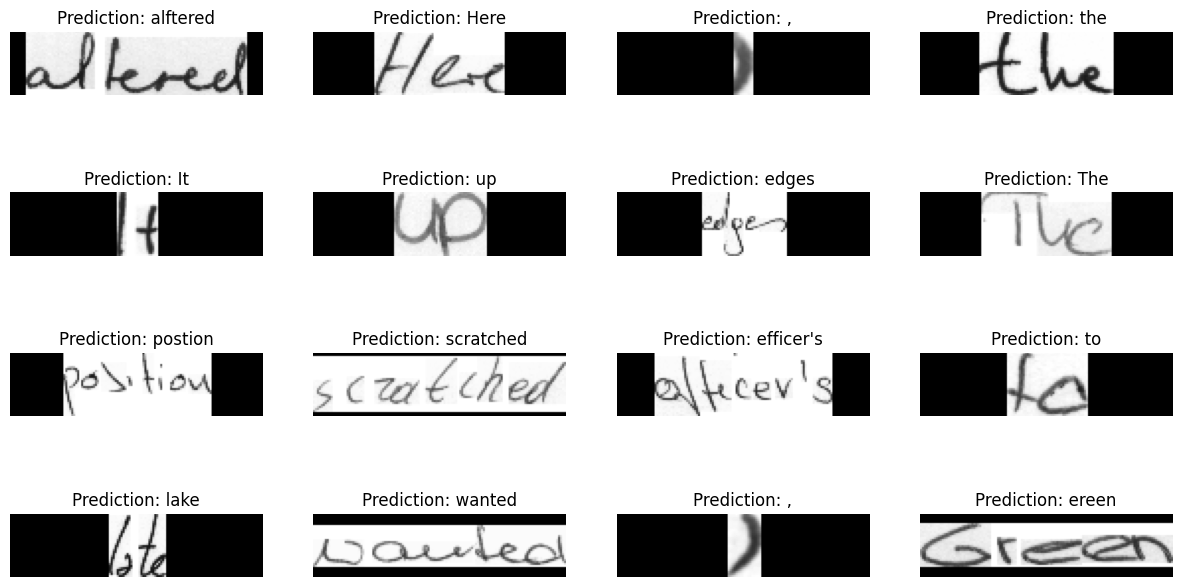

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
      output_text.append(res)

    return output_text


# Let's check results on sone test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    print(batch_images.shape)

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()

In [ ]:
custom_objects = {"CTCLayer": CTCLayer}

In [1]:
prediction_model = keras.models.Model(
  reconstructed_model.get_layer(name="image").input, reconstructed_model.get_layer(name="dense2").output
)

NameError: name 'keras' is not defined

(64, 128, 32, 1)
2/2 [==============================] - 3s 10ms/step


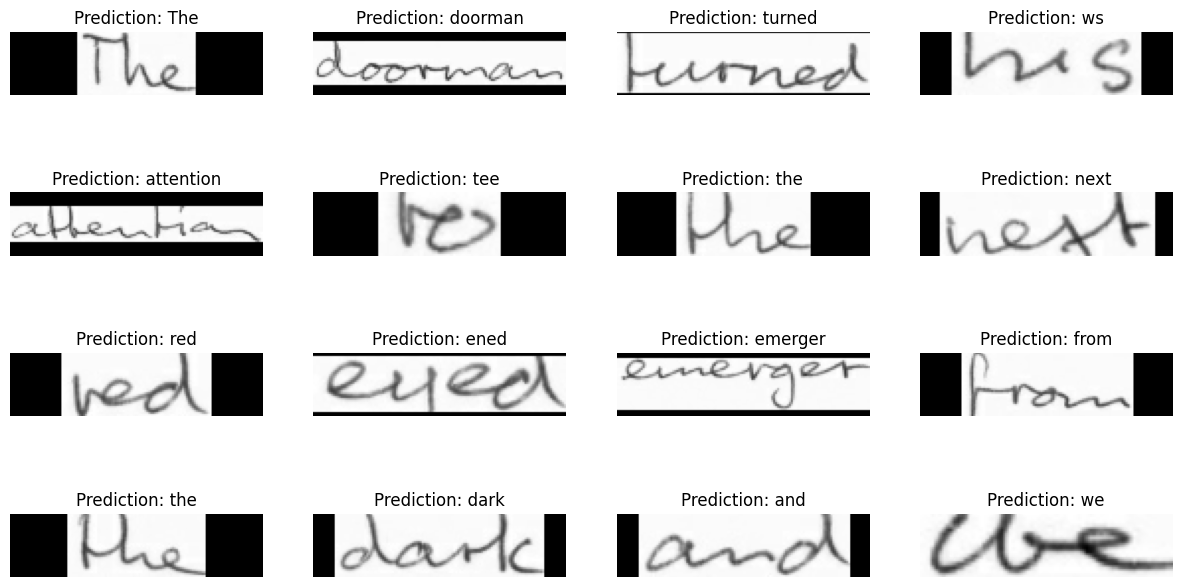

(18, 128, 32, 1)
1/1 [==============================] - 2s 2s/step


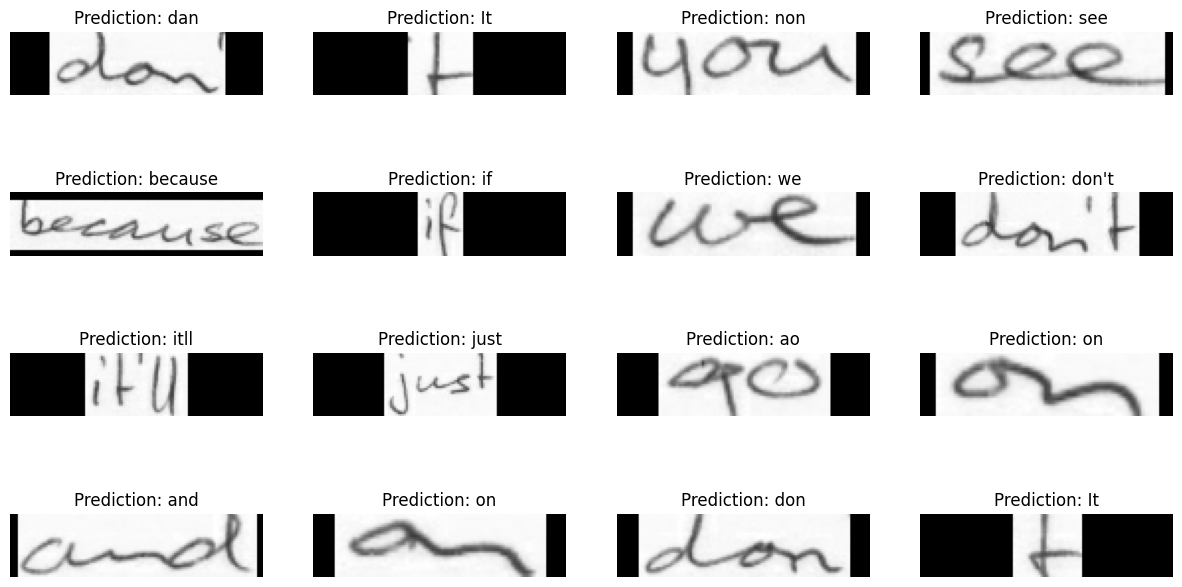

In [ ]:
pred_test_text = []

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
      res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
      res = tf.strings.reduce_join(num_to_chars(res)).numpy().decode("utf-8")
      output_text.append(res)

    return output_text


# Let's check results on sone test samples.
for batch in inf_images.take(3):
    batch_images = batch["image"]
    # batch_images= tf.expand_dims(batch_images, axis=0)
    print(batch_images.shape)
    # print(batch_images.shape)
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    pred_test_text.append(pred_texts)

    for i in range(16):
      img = batch_images[i]
      img = tf.image.flip_left_right(img)
      img = tf.transpose(img, perm=[1, 0, 2])
      img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
      img = img[:, :, 0]

      title = f"Prediction: {pred_texts[i]}"
      ax[i // 4, i % 4].imshow(img, cmap = "gray")
      ax[i // 4, i % 4].set_title(title)
      ax[i // 4, i % 4].axis("off")

    plt.show()

In [ ]:
flat_list = [item for sublist in pred_test_text for item in sublist]
print(flat_list)

['The', 'doorman', 'turned', 'ws', 'attention', 'tee', 'the', 'next', 'red', 'ened', 'emerger', 'from', 'the', 'dark', 'and', 'we', 'went', 'on', 'toaether', 'to', 'the', 'station', 'the', 'children', 'silent', 'because', 'of', 'the', 'cruelty', 'of', 'the', 'world', 'Finally', 'Catherine', 'sond', 'her', 'eyes', 'wet', 'agan', 'think', 'its', 'all', 'absdutely', 'beasthyy', 'and', 'I', 'can', 'It', 'bear', 'tothink', 'about', 'it', 'And', 'pl', 'hilip', 'sond', 'But', 'we', 've', 'aot', 'to', 'think', 'about', 'it', 'dan', 'It', 'non', 'see', 'because', 'if', 'we', "don't", 'itll', 'just', 'ao', 'on', 'and', 'on', 'don', 'It', 'non', 'see']


In [ ]:
sentence = ' '.join(flat_list)
sentence

"The doorman turned ws attention tee the next red ened emerger from the dark and we went on toaether to the station the children silent because of the cruelty of the world Finally Catherine sond her eyes wet agan think its all absdutely beasthyy and I can It bear tothink about it And pl hilip sond But we ve aot to think about it dan It non see because if we don't itll just ao on and on don It non see"

In [ ]:
from collections import defaultdict
from dataclasses import dataclass
from typing import List

import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import math

@dataclass
class BBox:
    x: int
    y: int
    w: int
    h: int


@dataclass
class DetectorRes:
    img: np.ndarray
    bbox: BBox


def detect(img: np.ndarray,
           kernel_size: int,
           sigma: float,
           theta: float,
           min_area: int) -> List[DetectorRes]:
    assert img.ndim == 2
    assert img.dtype == np.uint8

    # apply filter kernel
    kernel = _compute_kernel(kernel_size, sigma, theta)
    img_filtered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    img_thres = 255 - cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # append components to result
    res = []
    components = cv2.findContours(img_thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < min_area:
            continue
        # append bounding box and image of word to result list
        x, y, w, h = cv2.boundingRect(c)  # bounding box as tuple (x, y, w, h)
        crop = img[y:y + h, x:x + w]
        res.append(DetectorRes(crop, BBox(x, y, w, h)))

    return res


def _compute_kernel(kernel_size: int,
                    sigma: float,
                    theta: float) -> np.ndarray:

    assert kernel_size % 2  # must be odd size

    # create coordinate grid
    half_size = kernel_size // 2
    xs = ys = np.linspace(-half_size, half_size, kernel_size)
    x, y = np.meshgrid(xs, ys)

    # compute sigma values in x and y direction, where theta is roughly the average x/y ratio of words
    sigma_y = sigma
    sigma_x = sigma_y * theta

    # compute terms and combine them
    exp_term = np.exp(-x ** 2 / (2 * sigma_x) - y ** 2 / (2 * sigma_y))
    x_term = (x ** 2 - sigma_x ** 2) / (2 * math.pi * sigma_x ** 5 * sigma_y)
    y_term = (y ** 2 - sigma_y ** 2) / (2 * math.pi * sigma_y ** 5 * sigma_x)
    kernel = (x_term + y_term) * exp_term

    # normalize and return kernel
    kernel = kernel / np.sum(kernel)
    return kernel


def prepare_img(img: np.ndarray,
                height: int) -> np.ndarray:
    assert img.ndim in (2, 3)
    assert height > 0
    assert img.dtype == np.uint8
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def _cluster_lines(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    # compute matrix containing Jaccard distances (which is a proper metric)
    num_bboxes = len(detections)
    dist_mat = np.ones((num_bboxes, num_bboxes))
    for i in range(num_bboxes):
        for j in range(i, num_bboxes):
            a = detections[i].bbox
            b = detections[j].bbox
            if a.y > b.y + b.h or b.y > a.y + a.h:
                continue
            intersection = min(a.y + a.h, b.y + b.h) - max(a.y, b.y)
            union = a.h + b.h - intersection
            iou = np.clip(intersection / union if union > 0 else 0, 0, 1)
            dist_mat[i, j] = dist_mat[j, i] = 1 - iou  # Jaccard distance is defined as 1-iou

    dbscan = DBSCAN(eps=max_dist, min_samples=min_words_per_line, metric='precomputed').fit(dist_mat)

    clustered = defaultdict(list)
    for i, cluster_id in enumerate(dbscan.labels_):
        if cluster_id == -1:
            continue
        clustered[cluster_id].append(detections[i])

    res = sorted(clustered.values(), key=lambda line: [det.bbox.y + det.bbox.h / 2 for det in line])
    return res


def sort_multiline(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    lines = _cluster_lines(detections, max_dist, min_words_per_line)
    res = []
    for line in lines:
        res += sort_line(line)
    return res


def sort_line(detections: List[DetectorRes]) -> List[List[DetectorRes]]:
    """Sort the list of detections according to x-coordinates of word centers."""
    return [sorted(detections, key=lambda det: det.bbox.x + det.bbox.w / 2)]

<ipython-input-56-585cfe7d258c>:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('rainbow', num_colors)


15 13 77 41
['line0word0.jpg']
118 18 235 40
['line0word0.jpg', 'line0word1.jpg']
383 18 159 37
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg']
568 36 69 23
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg']
666 25 240 34
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg']
20 122 41 21
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg', 'line1word0.jpg']
84 110 72 34
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg', 'line1word0.jpg', 'line1word1.jpg']
198 117 95 28
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg', 'line1word0.jpg', 'line1word1.jpg', 'line1word2.jpg']
325 118 71 30
['line0word0.jpg', 'line0word1.jpg', 'line0word2.jpg', 'line0word3.jpg', 'line0word4.jpg', 'line1word0.jpg', 'line1word1.jpg', 'line1word2.jpg', 'line1word3.jpg']
418 127 110 24
['line0word0.jpg', 'line0word1.jpg', 'line0wo

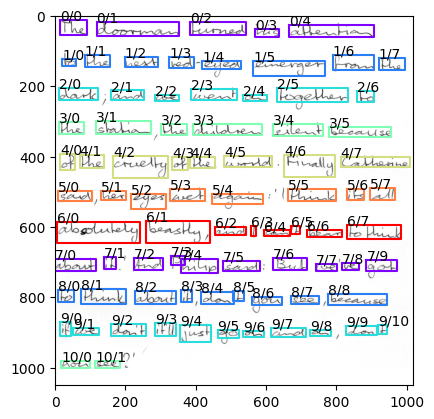

In [ ]:
from keras.layers import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

import numpy as np
import os
import re


########################################################################################################
##########################   Here is text detection part  ##############################################


from PIL import Image as im
import numpy as np
from word_dec import detect, prepare_img, sort_multiline
#from path import Path
import matplotlib.pyplot as plt
import cv2
from typing import List
import argparse

list_img_names_serial = []

input_path = "r06-137.png"
def save_image_names_to_text_files():

        # load image and process it
        img = prepare_img(cv2.imread(input_path), 1000)
        detections = detect(img,
                            kernel_size=25,
                            sigma=11,
                            theta=7,
                            min_area=100)

        # sort detections: cluster into lines, then sort each line
        lines = sort_multiline(detections)

        # plot results
        plt.imshow(img, cmap='gray')
        num_colors = 7
        colors = plt.cm.get_cmap('rainbow', num_colors)
        for line_idx, line in enumerate(lines):
            for word_idx, det in enumerate(line):
                xs = [det.bbox.x, det.bbox.x, det.bbox.x +
                      det.bbox.w, det.bbox.x + det.bbox.w, det.bbox.x]
                ys = [det.bbox.y, det.bbox.y + det.bbox.h,
                      det.bbox.y + det.bbox.h, det.bbox.y, det.bbox.y]
                plt.plot(xs, ys, c=colors(line_idx % num_colors))
                plt.text(det.bbox.x, det.bbox.y, f'{line_idx}/{word_idx}')
                print(det.bbox.x, det.bbox.y, det.bbox.w, det.bbox.h)
                crop_img = img[det.bbox.y:det.bbox.y +
                               det.bbox.h, det.bbox.x:det.bbox.x+det.bbox.w]

                path = './test_images'
                # Check whether the specified
                # path exists or not
                isExist = os.path.exists(path)
                if isExist == False:
                    os.mkdir(path)
                    print("Directory Created")

                cv2.imwrite(f"{path}/line" + str(line_idx) + "word" +
                            str(word_idx) + ".jpg", crop_img)
                full_img_path = "line" + \
                    str(line_idx) + "word" + str(word_idx)+".jpg"
                list_img_names_serial.append(full_img_path)
                print(list_img_names_serial)
                list_img_names_serial_set = set(list_img_names_serial)

                textfile = open("img_names_sequence.txt", "w")
                for element in list_img_names_serial:
                    textfile.write(element + "\n")
                textfile.close()

        plt.show()


save_image_names_to_text_files()